In [1]:
# 导入函数库和数据
import numpy as np
from scipy.integrate import odeint # 微分方程函数
from scipy.optimize import minimize # 优化函数
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
sns.set_style("darkgrid") # 设置图表风格
sns.set_context("paper")
plt.rcParams["font.sans-serif"]=["SimHei"] # 解决中文标题，坐标轴名，刻度名等问题
plt.rcParams["axes.unicode_minus"]=False  
import openpyxl # 用于打开excel表格
import palettable # 用于打开excel子表

df = pd.read_excel("data/3月12日至4月13日长春市疫情动态.xlsx")

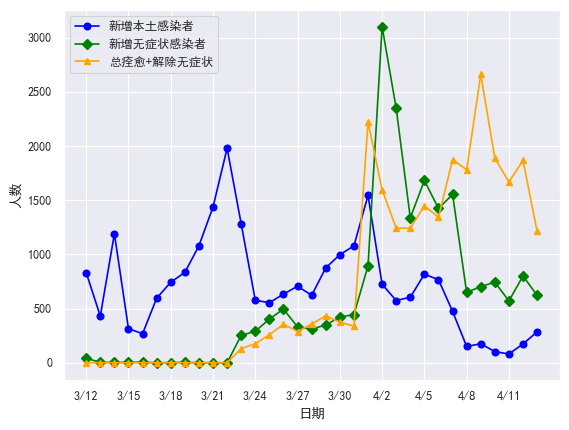

In [16]:
# 问题1
# 绘制疫情动态图
X = np.array(range(1,34))
X_label = ["3/12", "3/15", "3/18", "3/21", "3/24", "3/27", "3/30", "4/2", "4/5", "4/8", "4/11"]

Y1 = df["新增本土感染者"]
Y2 = df["新增无症状感染者"]
Y3 = df["痊愈+解除无症状"]
plt.plot(X, Y1, color="blue",marker="o", label="新增本土感染者")
plt.plot(X, Y2, color="green",marker="D", label="新增无症状感染者")
plt.plot(X, Y3, color="orange",marker="^", label="总痊愈+解除无症状")
plt.xlabel("日期")
plt.ylabel("人数")
plt.xticks([1,4,7,10,13,16,19,22,25,28,31], labels=X_label)
plt.legend(loc="upper left")
plt.savefig("figure/3月12日至4月13日长春市疫情动态.png")
plt.show()

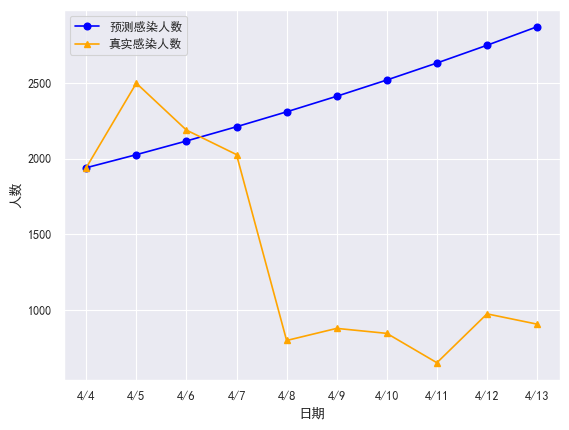

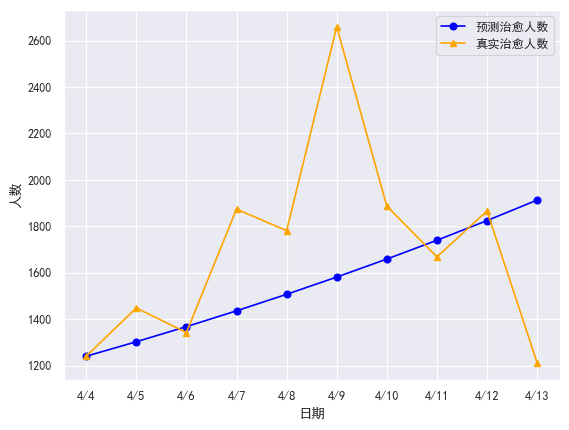

0.07508426211645923 0.03147329163263483
0.06924306924085921 0.04676871851957661


In [3]:
# 问题1
# 数据
Infected = df["新增本土感染者"] + df["新增无症状感染者"]
Recovered = df["痊愈+解除无症状"]

# SIR模型构建
class SIRModel:
    def __init__(self, beta, gamma, method): # 参数：传播率、移除率和优化计算方法
        self.__beta = beta
        self.__gamma = gamma
        self.__method = method  
        self.__optimal = None
        self.__predict_loss = None

    def sir_model(self, y0, t, beta, gamma): # SIR模型微分方程定义
        S, I, R = y0
        dSdt = -beta*S*I/(S+I+R)
        dIdt = beta*S*I/(S+I+R) - gamma*I
        dRdt = gamma*I
        return [dSdt, dIdt, dRdt]
    
    def loss_function(self, params, infected, recovered, y0): # 模型损失函数定义
        size = len(infected)
        t = np.linspace(1,size,size)
        beta, gamma = params
        solution = odeint(self.sir_model, y0, t, args=(beta, gamma))
        l1 = np.mean((solution[:,1] - infected)**2)
        l2 = np.mean((solution[:,2] - recovered)**2)
        return l1+l2

    def fit(self, y0, infected, recovered): # 模型拟合
        self.__optimal = minimize(self.loss_function, [self.__beta, self.__gamma],
                                args=(infected, recovered, y0),
                                method=self.__method, 
                                bounds=[(0.00000001, 1), (0.00000001, 1)])
    
    def predict(self, pre_y0, days):
        predict_result = odeint(self.sir_model, pre_y0, np.linspace(1,days,days), args=tuple(self.__optimal.x))
        return predict_result
    
    def get_optimal_params(self): # 返回优化后模型参数值
        return self.__optimal.x


# 思路1：构建从3月12日至4月3日的SIR模型，然后用于预测未来10天（4号-13号）的感染和治愈情况，并与真实情况做比对。
Infected_sub = Infected[:23] # 3月12日至4月3日感染情况
Recovered_sub = Recovered[:23] # 3月12日至4月3日治愈情况
N = 35000000 # 全市总隔离人数（九个区总和+其他下辖县市的预估总人数）
# 模型初值
I0 = Infected_sub[0] # 3月12日数据作为初值
R0 = Recovered_sub[0]
y0 = [N-I0-R0, I0, R0]
model = SIRModel(1, 1, "L-BFGS-B") # 有限内存下的拟牛顿法
model.fit(y0, Infected_sub, Recovered_sub) # SIR模型拟合
# 预测初值
I0 = Infected[23] # 4月4日数据作为初值
R0 = Recovered[23]
pre_y0 = [N-I0-R0, I0, R0]
predict_result = np.array(model.predict(pre_y0,10)).T

Infected_pre = predict_result[1] # 预测的传染人数（本土感染+无症状）
Recovered_pre = predict_result[2] # 预测的治愈人数
Infected_real = Infected[23:] # 真实的传染人数
Recovered_real = Recovered[23:] # 真实的治愈人数

X = np.array(range(1,11))
X_label = ["4/4", "4/5", "4/6", "4/7", "4/8", "4/9", "4/10", "4/11", "4/12", "4/13"]
# 预测感染 vs 真实感染
plt.plot(X, Infected_pre, color="blue", marker="o", label = "预测感染人数")
plt.plot(X, Infected_real, color="orange", marker="^", label = "真实感染人数")
plt.xlabel("日期")
plt.ylabel("人数")
plt.xticks(X, labels=X_label)
plt.legend()
plt.savefig("figure/预测感染人数 vs 真实感染人数.png")
plt.show()
# 预测治愈 vs 真实治愈
plt.plot(X, Recovered_pre, color="blue", marker="o", label = "预测治愈人数")
plt.plot(X, Recovered_real, color="orange", marker="^", label = "真实治愈人数")
plt.xlabel("日期")
plt.ylabel("人数")
plt.xticks(X, labels=X_label)
plt.legend()
plt.savefig("figure/预测治愈人数 vs 真实治愈人数.png")
plt.show()


# 思路2：以4月3日为界，构建前后两个SIR模型，比较beta和gamma值
Infected_sub1 = Infected[:23]
Recovered_sub1 = Recovered[:23]
I0 = Infected_sub1[0]
R0 = Recovered_sub1[0]
y0 = [N-I0-R0, I0, R0]
model = SIRModel(1, 1, "L-BFGS-B")
model.fit(y0, Infected_sub1, Recovered_sub1)
print(model.get_optimal_params()[0], model.get_optimal_params()[1])

Infected_sub2 = Infected[:]
Recovered_sub2 = Recovered[:]
I0 = Infected_sub2[0]
R0 = Recovered_sub2[0]
y0 = [N-I0-R0, I0, R0]
model = SIRModel(1, 1, "L-BFGS-B")
model.fit(y0, Infected_sub2, Recovered_sub2)
print(model.get_optimal_params()[0], model.get_optimal_params()[1])